# Binary Image Classification

We cover the following recipes:
- Exploring the dataset
- Creating a custom dataset
- Splitting the dataset
- Transforming the dataset
- Creating dataloaders
- Building the classification model
- Defining the loss function
- Defining the optimizer
- Training and evaluation of the model
- Deploying the model
- Model inference on test data

# Exploring the dataset

### 1. Let's begin by reading train_labels.csv and printing out its head:

In [1]:
import pandas as pd

path2csv = "./data/histopathologic-cancer-detection/train_labels.csv"
labels_df = pd.read_csv(path2csv)
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


### 2. Let's count the number of normal and malignant cases:

In [2]:
print(labels_df['label'].value_counts())

0    130908
1     89117
Name: label, dtype: int64


- Normal = 0
- Malignant = 1

### 3. Let's look at a histogram of the labels

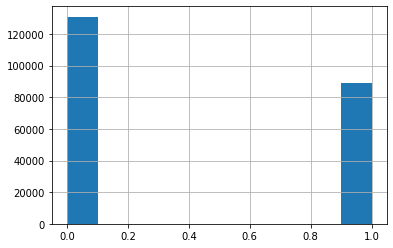

In [3]:
%matplotlib inline
labels_df['label'].hist()

### 4. Let's visualize a few images that have a positive label. A positive label shows that the center 32x32 region of an image contains at least one pixel of tumor tissue. First, we import the required packages:

In [25]:
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import numpy as np
import os
%matplotlib inline

Then, we get the IDs of the malignant images:

In [5]:
# get ids for malignant images
malignant_ids = labels_df.loc[labels_df['label']==1]['id'].values

Define the path to data:

In [6]:
# data is stored here
path2train = "./data/histopathologic-cancer-detection/train/"

Next, we define a flag to show images in grayscale or color mode:

In [7]:
# show images in grayscale, if you want color change it to True
color = True

Next, we set the figure sizes:

In [8]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows, ncols = 3,3

<Figure size 720x720 with 0 Axes>

Next, we display the images:

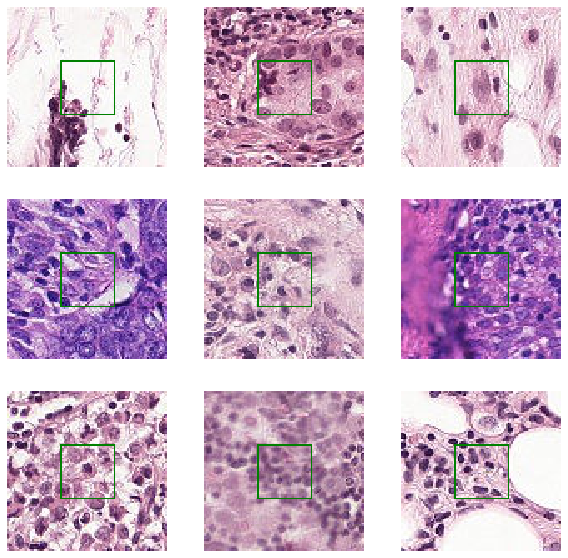

In [9]:
for i, id_ in enumerate(malignant_ids[:nrows * ncols]):
    full_filenames = os.path.join(path2train, id_ + '.tif')
    
    # load image
    img = Image.open(full_filenames)
    
    # draw a 32*32 rectangle
    draw = ImageDraw.Draw(img)
    draw.rectangle(((32, 32), (64, 64)), outline="green")
    plt.subplot(nrows, ncols, i+1)
    
    if color is True:
        plt.imshow(np.array(img))
    else:
        plt.imshow(np.array(img)[:, :, 0], cmap="gray")
    plt.axis('off')

### 5. Let's also get the image's shape and minimum and maximum pixel values:

In [10]:
print("image shape:", np.array(img).shape)
print("pixel values range from %s to %s" % (np.min(img), np.max(img)))

image shape: (96, 96, 3)
pixel values range from 0 to 255


# Creating a custom dataset

Traditional method: Load all images into NumPy arrays. Not good for large datasets.

### 1. Let's create a PyTorch custom dataset for our data: 

In [10]:
# Load the required packages

from PIL import Image
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transforms
import os

Don't forget to fix the random seed for reproducibility:

In [12]:
# fix torch random seed
torch.manual_seed(0)

Define the histoCancerDataset class:

In [50]:
class HistoCancerDataset(Dataset):
    def __init__(self, data_dir, transform, data_type="train"):
        # path tom images
        path2data = os.path.join(data_dir, data_type)
        
        # get a list of images
        self.filenames = os.listdir(path2data)
        
        # get the full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in self.filenames]
        
        # labels are in a csv file named train_labels.csv
        csv_filename = data_type + "_labels.csv"
        path2csv_labels = os.path.join(data_dir, csv_filename)
        labels_df = pd.read_csv(path2csv_labels)
        
        # set data frame index to id
        labels_df.set_index("id", inplace=True)
        
        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for 
                      filename in self.filenames]
        
        self.transform = transform
        
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx]) # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

### 2. Next, we will define a simple transformation that only converts a PIL image into PyTorch tensors. Later, we will expand this:

In [18]:
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor()])

### 3. Then, we will define an object of the custom dataset for the train folder:

In [19]:
data_dir = "./data/histopathologic-cancer-detection/"
histo_dataset = HistoCancerDataset(data_dir, data_transformer,
                                   "train")
print(len(histo_dataset))

220025


### 4. Next, we will load an image using the custom dataset:

In [16]:
# load an image
img, label = histo_dataset[9]
print(img.shape, torch.min(img), torch.max(img))

torch.Size([3, 96, 96]) tensor(0.) tensor(1.)


ToTensor() converts a PIL image into the range[0, 255] to torch.FloatTensor of shape(CxHxW) in the range[0.0, 1.0].

## Splitting the dataset

### 1. Let's split histo_dataset:

In [20]:
from torch.utils.data import random_split

len_histo = len(histo_dataset)
len_train = int(0.8 * len_histo)
len_val = len_histo - len_train

train_ds, val_ds = random_split(histo_dataset, [len_train, len_val])

print("train dataset length:", len(train_ds))
print("validation dataset length:", len(val_ds))

train dataset length: 176020
validation dataset length: 44005


### 2. Then, we can get an image from the training dataset:

In [18]:
for x,y in train_ds:
    print(x.shape, y)
    break

torch.Size([3, 96, 96]) 0


### 3. We will also get an image from the validation dataset: 

In [19]:
for x,y in val_ds:
    print(x.shape, y)
    break

torch.Size([3, 96, 96]) 1


### 4. Let's display a few samples from train_ds:

In [20]:
# Import the required packages
from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

Define a helper function to show an image:

In [21]:
def show(img, y, color=False):
    # convert tensor to numpy array
    np_img = img.numpy()
    
    # convert to H*W*C shape
    np_img_tr = np.transpose(np_img, (1, 2, 0))
    
    if color==False:
        np_img_tr = np_img_tr[:, :, 0]
        plt.imshow(np_img_tr, interpolation='nearest', cmap='gray')
    else:
        # display images
        plt.imshow(np_img_tr, interpolation='nearest')
    plt.title("label: " + str(y))

Create a grid of sample images:

In [22]:
grid_size = 4
rnd_inds = np.random.randint(0, len(train_ds), grid_size)
print("image indices:", rnd_inds)

x_grid_train = [train_ds[i][0] for i in rnd_inds]
y_grid_train = [train_ds[i][1] for i in rnd_inds]

x_grid_train = utils.make_grid(x_grid_train, nrow=4, padding=2)
print(x_grid_train.shape)

image indices: [ 43567 173685 117952 152315]
torch.Size([3, 100, 394])


Call the helper function to display the grid:

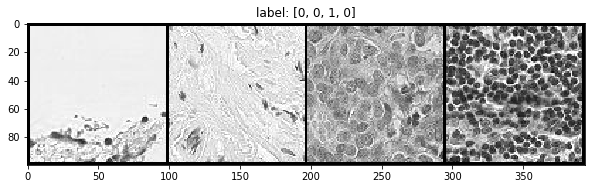

In [23]:
plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_train, y_grid_train)

### 5. We can also show a few samples from val_ds:

image indices: [30403 32103 41993 20757]
torch.Size([3, 100, 394])


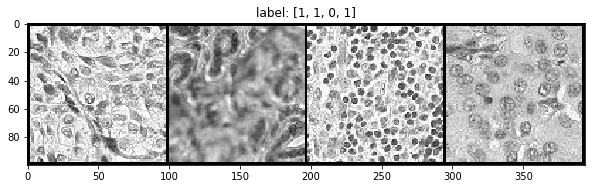

In [24]:
grid_size = 4
rnd_inds = np.random.randint(0, len(val_ds), grid_size)
print("image indices:", rnd_inds)
x_grid_val = [val_ds[i][0] for i in range(grid_size)]
y_grid_val = [val_ds[i][1] for i in range(grid_size)]

x_grid_val = utils.make_grid(x_grid_val, nrow=4, padding=2)
print(x_grid_val.shape)

show(x_grid_val, y_grid_val)

## Transforming the data

### 1. First, let's define the following transformation for the training dataset:

In [15]:
train_transformer = transforms.Compose([
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.RandomRotation(45),
                        transforms.RandomResizedCrop(96,
                                                     scale=(0.8, 1.0),
                                                     ratio=(1.0, 1.0)),
                        transforms.ToTensor()
])

### 2. For the validation dataset, we don't need any augmentation. So, we only convert the images into tensors in the transforms function:

In [13]:
val_transformer = transforms.Compose([transforms.ToTensor()])

### 3. After defining the transformations, we overwrite the transform functions of train_ds and val_ds:

In [21]:
# overwrite the transform functions
train_ds.transform = train_transformer
val_ds.transform = val_transformer

## Creating dataloaders

### 1. First, let's define two dataloaders for the datasets:

In [28]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)

### 2. Then, we get a data batch from the training dataloader:

In [29]:
# extract a batch from training data
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 96, 96])
torch.Size([32])


### 3. Next, we get a data batch from the validation dataloader:

In [30]:
for x, y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 3, 96, 96])
torch.Size([64])


## Building the classification model

### 1. First, let's create dumb baselines for the validation dataset.

First, we will get the labels for the validation dataset:

In [31]:
# get labels for validation dataset
y_val = [y for _,y in val_ds]

Next, we will define a function to calculate the classification accuracy:

In [32]:
def accuracy(labels, out):
    return np.sum(out==labels)/float(len(labels))

Then, we will calculate a dumb baseline for all-zero predictions:

In [33]:
# accuracy all zero predictions
acc_all_zeros = accuracy(y_val, np.zeros_like(y_val))
print("accuracy all zero prediction: %.2f" %acc_all_zeros)

accuracy all zero prediction: 0.59


Next, we will calculate a dumb baseline for all-one predictions:

In [34]:
# accuracy all ones predictions
acc_all_ones = accuracy(y_val, np.ones_like(y_val))

print("accuracy all one predictions: %.2f" %acc_all_ones)

accuracy all one predictions: 0.41


Next, we will calculate a dumb baseline for random predictions:

In [35]:
# accuracy random predictions
acc_random = accuracy(y_val, np.random.randint(2, size=len(y_val)))

print("accuracy random prediction: %.2f" %acc_random)

accuracy random prediction: 0.50


### 2. Let's implement a helper function to calculate the output of a CNN layer:

In [36]:
import torch.nn as nn
import numpy as np

In [23]:
def find_conv2d_out_shape(h_in, w_in, conv, pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation
    
    # Ref: https://pytorch.org/docs/stable/nn.html
    h_out = np.floor((h_in + 2 * padding[0] -
                      dilation[0] * 
                      (kernel_size[0] - 1) - 1)/stride[0] + 1)
    
    w_out = np.floor((w_in + 2 * padding[1] - 
                     dilation[1] * (kernel_size[1] - 1) - 1) / 
                    stride[1] + 1)
    
    if pool:
        h_out = h_out / pool
        w_out = w_out / pool
        
    return int(h_out), int(w_out)

In [38]:
# example
conv1 = nn.Conv2d(3, 8, kernel_size=3)
h, w = find_conv2d_out_shape(96, 96, conv1)
print(h, w)

47 47


### 3. Next, we will implement the CNN model.

In [3]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
        c_in, h_in, w_in = params["input_shape"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]
        
        self.conv1 = nn.Conv2d(c_in, init_f, kernel_size=3)
        h, w = find_conv2d_out_shape(h_in, w_in, self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h, w = find_conv2d_out_shape(h, w, self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h, w = find_conv2d_out_shape(h, w, self.conv3)
        
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h, w = find_conv2d_out_shape(h, w, self.conv4)
        
        # compute the flatten size
        self.num_flatten = h * w * 8 * init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, self.num_flatten)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, self.dropout_rate, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### 4. Then, we will construct an object of the Net class:

In [41]:
# dict to define model parameters
params_model = {
                "input_shape": (3, 96, 96),
                "initial_filters": 8,
                "num_fc1": 100,
                "dropout_rate": 0.25,
                "num_classes": 2,
}

# create model
cnn_model = Net(params_model)

### 5. Move the model to a cuda device if one's available:

In [42]:
# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    cnn_model = cnn_model.to(device)

### 6. Print the model:

In [43]:
print(cnn_model)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


### 7. Verify the model device:

In [44]:
print(next(cnn_model.parameters()).device)

cuda:0


### 8. Let's get a summary of the model:

In [45]:
from torchsummary import summary
summary(cnn_model, input_size=(3, 96, 96), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 94, 94]             224
            Conv2d-2           [-1, 16, 45, 45]           1,168
            Conv2d-3           [-1, 32, 20, 20]           4,640
            Conv2d-4             [-1, 64, 8, 8]          18,496
            Linear-5                  [-1, 100]         102,500
            Linear-6                    [-1, 2]             202
Total params: 127,230
Trainable params: 127,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.92
Params size (MB): 0.49
Estimated Total Size (MB): 1.51
----------------------------------------------------------------


It is interesting to see that the fully connected layer has the highest number of parameters, which is not efficient. Therefore, state-of-the-art deep learning models eliminate fully connected layers in their design.

## Defining the loss function

The standard loss function for classification tasks is cross-entropy or log-loss. However, when defining the loss function, we need to consider the number of model outputs and their activation functions.

### 1. First, let's define the loss function, as follows:

In [46]:
loss_func = nn.NLLLoss(reduction="sum")

### 2. Next, we will use the loss in an example:

In [47]:
# fix random seed
torch.manual_seed(0)

n, c = 8, 2
y = torch.randn(n, c, requires_grad=True)
ls_f = nn.LogSoftmax(dim=1)
y_out = ls_f(y)
print(y_out.shape)

target = torch.randint(c, size=(n,))
print(target.shape)

loss = loss_func(y_out, target)
print(loss.item())

torch.Size([8, 2])
torch.Size([8])
5.266995429992676


### 3. Then, we will compute the gradients of the loss with respect to y:

In [48]:
loss.backward()
print(y.data)

tensor([[-1.1258, -1.1524],
        [-0.2506, -0.4339],
        [ 0.8487,  0.6920],
        [-0.3160, -2.1152],
        [ 0.3223, -1.2633],
        [ 0.3500,  0.3081],
        [ 0.1198,  1.2377],
        [ 1.1168, -0.2473]])


## Defining the optimizer

### 1. First, let's define an object of the Adam optimizer with a learning rate of 3e-4:

In [49]:
from torch import optim
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)

### 2. We can read the current value of the learning rate using the following function:

In [50]:
# get learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
    
current_lr = get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0003


### 3. Next, we will define a learning scheduler using the ReduceLROnPlateau method:

In [51]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5,
                                 patience=20, verbose=1)

### 4. Then, we will learn how the learning rate schedule works using the following example:

In [52]:
for i in range(100):
    lr_scheduler.step(1)

Epoch    22: reducing learning rate of group 0 to 1.5000e-04.
Epoch    43: reducing learning rate of group 0 to 7.5000e-05.
Epoch    64: reducing learning rate of group 0 to 3.7500e-05.
Epoch    85: reducing learning rate of group 0 to 1.8750e-05.


The mode argument defines whether the metric quantity is increasing or decreasing during training. For instance, if we monitor the loss value, we set mode="min". If we monitor the accuracy, we should set mode="max".

## Training and evaluation of the model

### 1. First, let's develop a helper function to count the number of correct predictions per data batch:

In [53]:
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    # compare output class with target class
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

### 2. Then, we will develop a helper function to compute the loss value per batch of data:

In [54]:
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    with torch.no_grad():
        metric_b = metrics_batch(output, target)
        
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

### 3. Next, we develop a helper function to compute the loss value and the performance metric for the entire dataset, also called an epoch.

In [55]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)
    
    for xb, yb in dataset_dl:
        # move batch to device
        xb = xb.to(device)
        yb = yb.to(device)
        
        # get model output
        output = model(xb)
        
        # get loss per batch
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss = running_loss + loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric = running_metric + metric_b
            
        # break the loop in case of sanity check
        if sanity_check is True:
            break
            
    # average loss value
    loss = running_loss / float(len_data)
    
    # average metric value
    metric = running_metric / float(len_data)
    
    return loss, metric

### 4. Let's develop the train_val function in the following code blocks:

In [56]:
def train_val(model, params):
    # extract model parameters
    num_epochs = params["num_epochs"]
    loss_func = params["loss_func"]
    opt = params["optimizer"]
    train_dl = params["train_dl"]
    val_dl = params["val_dl"]
    sanity_check = params["sanity_check"]
    lr_scheduler = params["lr_scheduler"]
    path2weights = params["path2weights"]
    
    # history of loss values in each epoch
    loss_history = {
        "train": [],
        "val": [],
    }
    # history of metric values in each epoch
    metric_history = {
        "train": [],
        "val": [],
    }
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss = float('inf')
    
    # main loop
    for epoch in range(num_epochs):
        # get current learning rate
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, 
                                                  num_epochs - 1,
                                                  current_lr))
        # train model on training dataset:
        model.train()
        train_loss, train_metric = loss_epoch(model,
                                              loss_func,
                                              train_dl,
                                              sanity_check,
                                              opt)
        
        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate model on validation dataset
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,
                                              loss_func,
                                              val_dl,
                                              sanity_check)
            
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
                
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)
                
        print("train_loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss, val_loss, 100*val_metric))
        print("-"*10)
            
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

### 5. Let's set the sanity_check flag to True and run the code.

In [57]:
import copy
loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5,
                                 patience=20, verbose=1)

In [58]:
# define the training parameters and call the train_val helper function

params_train = {
    "num_epochs": 100,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": "./models/weights.pt",
}

# train and validate the model
cnn_model, loss_hist, metric_hist = train_val(cnn_model, params_train)

Epoch 0/99, current lr=0.0003
Copied best model weights!
train_loss: 0.462261, dev loss: 0.410449, accuracy: 82.20
----------
Epoch 1/99, current lr=0.0003
Copied best model weights!
train_loss: 0.387023, dev loss: 0.375116, accuracy: 83.58
----------
Epoch 2/99, current lr=0.0003
Copied best model weights!
train_loss: 0.350647, dev loss: 0.330367, accuracy: 85.93
----------
Epoch 3/99, current lr=0.0003
train_loss: 0.325963, dev loss: 0.331191, accuracy: 85.69
----------
Epoch 4/99, current lr=0.0003
Copied best model weights!
train_loss: 0.309052, dev loss: 0.297051, accuracy: 87.33
----------
Epoch 5/99, current lr=0.0003
Copied best model weights!
train_loss: 0.295837, dev loss: 0.294508, accuracy: 87.50
----------
Epoch 6/99, current lr=0.0003
Copied best model weights!
train_loss: 0.283120, dev loss: 0.282571, accuracy: 88.68
----------
Epoch 7/99, current lr=0.0003
Copied best model weights!
train_loss: 0.273626, dev loss: 0.274321, accuracy: 88.64
----------
Epoch 8/99, current

train_loss: 0.123709, dev loss: 0.257518, accuracy: 91.20
----------
Epoch 78/99, current lr=7.5e-05
train_loss: 0.121569, dev loss: 0.259405, accuracy: 91.30
----------
Epoch 79/99, current lr=7.5e-05
train_loss: 0.119696, dev loss: 0.263963, accuracy: 91.26
----------
Epoch 80/99, current lr=7.5e-05
train_loss: 0.117716, dev loss: 0.261394, accuracy: 91.25
----------
Epoch 81/99, current lr=7.5e-05
train_loss: 0.116265, dev loss: 0.268672, accuracy: 90.74
----------
Epoch 82/99, current lr=7.5e-05
train_loss: 0.115521, dev loss: 0.276353, accuracy: 91.02
----------
Epoch 83/99, current lr=7.5e-05
train_loss: 0.114055, dev loss: 0.268453, accuracy: 90.67
----------
Epoch 84/99, current lr=7.5e-05
train_loss: 0.112252, dev loss: 0.268843, accuracy: 91.21
----------
Epoch 85/99, current lr=7.5e-05
Epoch    86: reducing learning rate of group 0 to 3.7500e-05.
Loading best model weights!
train_loss: 0.110681, dev loss: 0.279149, accuracy: 90.88
----------
Epoch 86/99, current lr=3.75e-05


### 6. Let's plot the training validation's progress using the returned values, that is, loss_hist and metric_hist:

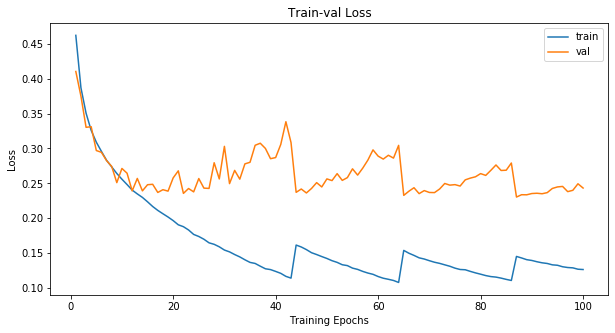

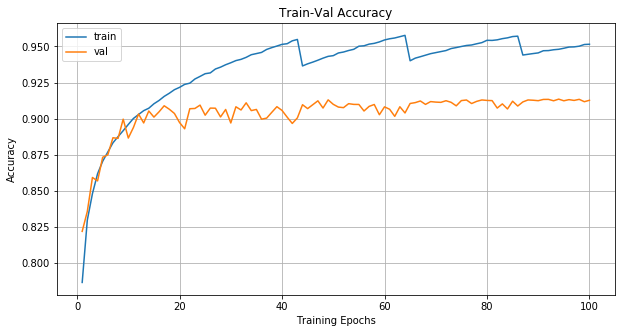

In [67]:
# Train validation progress
num_epochs = params_train["num_epochs"]

# plot loss progress
plt.title("Train-val Loss")
plt.plot(range(1, num_epochs+1), loss_hist["train"], label="train")
plt.plot(range(1, num_epochs + 1), loss_hist["val"], label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1, num_epochs + 1),
         metric_hist["train"],
         label="train")
plt.plot(range(1, num_epochs+1),
         metric_hist["val"],
         label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.grid()
plt.show()


### 7. By doing this, we've made sure that all the elements are implemented correctly. Let's set the flag to sanity_check: False and run the code. The training will start and we will see its progress, as shown in the following code block:

## Deploying the model

### 1. First, we'll create an object of the Net class and load the stored weights into the model:

In [26]:
# model parameters
params_model = {
    "input_shape": (3, 96, 96),
    "initial_filters": 8,
    "num_fc1": 100,
    "dropout_rate": 0.25,
    "num_classes": 2,
}

# initialize model
cnn_model = Net(params_model)

### 2. Let's load state_dict into the model:

In [27]:
# load state_dict into model
path2weights = "./models/weights.pt"
cnn_model.load_state_dict(torch.load(path2weights))

<All keys matched successfully>

### 3. Set the model in eval mode:

In [28]:
# set model in evaluation mode
cnn_model.eval()

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

### 4. Move the model onto a CUDA device if one's available:

In [32]:
# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    cnn_model = cnn_model.to(device)

### 5. Let's develop a helper function to deploy the model on a dataset:

In [6]:
# define the deploy_model function
import time
def deploy_model(model, dataset, device, num_classes=2,
                 sanity_check=False):
    len_data = len(dataset)
    # initialize output tensor on CPU: due to GPU memory limits
    y_out = torch.zeros(len_data, num_classes)
    # initialize ground trugh on CPU: due to GPU memory limits
    y_gt = np.zeros((len_data), dtype="uint8")
    # move model to device
    model = model.to(device)
    
    elapsed_times = []
    with torch.no_grad():
        for i in range(len_data):
            x, y = dataset[i]
            y_gt[i] = y
            start = time.time()
            y_out[i] = model(x.unsqueeze(0).to(device))
            elapsed = time.time() - start
            elapsed_times.append(elapsed)
            
            if sanity_check is True:
                break
        
    inference_time = np.mean(elapsed_times) * 1000
    print("average inference time per image on %s: %.2f ms"
         % (device, inference_time))
    return y_out.numpy(), y_gt        

### 6. Let's use this function to deploy the model on the validation dataset:

In [33]:
# deploy model
y_out, y_gt = deploy_model(cnn_model, val_ds, device=device,
                           sanity_check=False)
print(y_out.shape, y_gt.shape)

average inference time per image on cuda: 2.65 ms
(44005, 2) (44005,)


### 7. Let's calculate the accuracy of the model on the validation dataset using the predicted outputs:

In [34]:
from sklearn.metrics import accuracy_score

# get predictions
y_pred = np.argmax(y_out, axis=1)
print(y_pred.shape, y_gt.shape)

# compute accuracy
acc = accuracy_score(y_pred, y_gt)
print("accuracy: %.2f" % acc)

(44005,) (44005,)
accuracy: 0.94


### 8. Let's also measure the inference time on the CPU device:

In [31]:
device_cpu = torch.device("cpu")
y_out, y_gt = deploy_model(cnn_model, val_ds,
                           device=device_cpu,
                           sanity_check=False)
print(y_out.shape, y_gt.shape)

KeyboardInterrupt: 

 # Model inference on test data

### 1. First, let's load test_labels.csv and print out its head:

In [35]:
path2csv = "./data/histopathologic-cancer-detection/test_labels.csv"
labels_df = pd.read_csv(path2csv)
labels_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


### 2. Create a dataset object for the test dataset:

In [51]:
data_path = "./data/histopathologic-cancer-detection/"
histo_test = HistoCancerDataset(data_path,
                                val_transformer,
                                data_type="test")
print(len(histo_test))

57458


In [52]:
histo_test.filenames

['e6113c100d1f63ce51771e7b5f0569d875c9bfef.tif',
 '77cc07a6ba6a4123fe4908ca02d94e967248769c.tif',
 'b9d32f101b821924c919f997466da1e4ab27de98.tif',
 'a4c638f879d931e00178233f0950924b43448404.tif',
 '8fb009b2600af7f2f8163545e7e0bbacff1fa7ce.tif',
 '2758830f0ba5aa86d1830e7d07c4b1dbd41dda61.tif',
 '0826bd607a4692e14cdd314d6918b3e01d3f98ed.tif',
 'efd174318cb689fbbb39a207b9bf66c27b70c41f.tif',
 '32b8e9ddd7d497cbd7854476d234f13aef6562c1.tif',
 'a4541f8a2db7e01185c3ee5122c6ff9b6bc2502c.tif',
 '45ba6218a0df6ffcd04898ce10ebc6be0b6c6ea2.tif',
 '633da562f25481185d29a5e4b114bf39bd5d43e9.tif',
 'af79b62c1f436da5b67533cf2a9f084a61c76b0f.tif',
 '496ccb79bcb122323314f240eead15d891640f19.tif',
 '945a071959fce059c2b263e864f8caf414b02fdd.tif',
 'aace19e6610864700580e89cd389302d97efd81f.tif',
 '07e9db433151fbe7b5c664be26ef1b93d12725d1.tif',
 'd9761207152aaf52485c7bfeeb2f703db6e9760d.tif',
 '0a21d51dca1cd8088b72f540850959dfc66d4576.tif',
 'e9d15be2acd9daa604acfcc3744a2a74a8481042.tif',
 '771fcae21e6596a096

### 3. Deploy the model on test dataset:

In [37]:
y_test_out,_ = deploy_model(cnn_model, histo_test, device,
                            sanity_check=False)

average inference time per image on cuda: 2.49 ms


### 4. Display a few images and predictions:

In [39]:
grid_size = 4
rnd_inds = np.random.randint(0, len(histo_test),
                             grid_size)
print("image indices:", rnd_inds)

x_grid_test = [histo_test[i][0] for i in range(grid_size)]
y_grid_test = [y_test_pred[i] for i in range(grid_size)]

x_grid_test = utils.make_grid(x_grid_test, nrow=4, padding=2)
print(x_grid_test.shape)

plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_test, y_grid_test)

image indices: [30713 29651  3376 35937]


NameError: name 'y_test_pred' is not defined

In [40]:
print(y_test_out.shape)
cancer_preds = np.exp(y_test_out[:, 1])
print(cancer_preds.shape)

(57458, 2)
(57458,)


In [53]:
path2sample_sub = "./data/histopathologic-cancer-detection/" + "sample_submission.csv"
sample_df = pd.read_csv(path2sample_sub)
ids_list = list(sample_df.id)
pred_list = [p for p in cancer_preds]
pred_dic = dict((key[:-4], value) for (key, value) in
               zip(histo_test.filenames, pred_list))
pred_list_sub = [pred_dic[id_] for id_ in ids_list]
submission_df = pd.DataFrame({'id':ids_list, 'label':pred_list_sub})

if not os.path.exists("./submissions/"):
    os.makedirs("submissions/")
    print("submission folder created!")
    
path2submission = "./submissions/submission.csv"
submission_df.to_csv(path2submission, header=True, index=False)
submission_df.head()

submission folder created!


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.215593
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.233779
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.002692
3,2c35657e312966e9294eac6841726ff3a748febf,0.133044
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.009533
